In [1]:
"""
Word2Vec 教学教程
本教程将带你了解Word2Vec的基本原理和实现。
我们将使用PyTorch实现一个简单的Word2Vec模型，
并通过可视化来理解词向量的含义。
"""

'\nWord2Vec 教学教程\n本教程将带你了解Word2Vec的基本原理和实现。\n我们将使用PyTorch实现一个简单的Word2Vec模型，\n并通过可视化来理解词向量的含义。\n'

In [2]:
# 1. 导入必要的库
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
import time
import jieba # 中文分词库
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random

In [3]:
# 设置随机种子，确保结果可复现
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [4]:
# 2. 准备示例数据
sentences = [
    "自然语言处理是人工智能的一个重要分支",
    "词嵌入是自然语言处理中的基础技术",
    "word2vec是一种常用的词嵌入模型",
    "词嵌入可以捕捉词语之间的语义关系",
    "中国是一个有着悠久历史的国家",
    "北京是中国的首都",
    "上海是中国的经济中心",
    "人工智能技术在各个领域得到了广泛应用",
    "深度学习是机器学习的一个重要分支",
    "自然语言处理技术可以帮助计算机理解人类语言"
] * 5  # 重复多次以增加样本量

In [6]:
# 展示分词效果
print("分词示例：")
for sentence in sentences[:2]:
    words = list(jieba.cut(sentence))
    print(f"原句：{sentence}")
    print(f"分词：{' '.join(words)}")
    print()

分词示例：
原句：自然语言处理是人工智能的一个重要分支
分词：自然语言 处理 是 人工智能 的 一个 重要 分支

原句：词嵌入是自然语言处理中的基础技术
分词：词 嵌入 是 自然语言 处理 中 的 基础 技术



In [7]:
# 3. 构建词汇表
def build_vocab(sentences):
    """构建词汇表"""
    word_counts = Counter()
    for sentence in sentences:
        # 使用jieba进行中文分词
        words = list(jieba.cut(sentence))
        word_counts.update(words)
    
    # 创建词到索引的映射
    word_to_idx = {word: i for i, word in enumerate(word_counts.keys())}
    idx_to_word = {i: word for word, i in word_to_idx.items()}
    
    return word_to_idx, idx_to_word, len(word_counts)

In [8]:
# 构建词汇表
word_to_idx, idx_to_word, vocab_size = build_vocab(sentences)

In [9]:
print(f"词汇表大小: {vocab_size}")
print("\n部分词汇示例：")
for word, idx in list(word_to_idx.items())[:10]:
    print(f"{word}: {idx}")

词汇表大小: 46

部分词汇示例：
自然语言: 0
处理: 1
是: 2
人工智能: 3
的: 4
一个: 5
重要: 6
分支: 7
词: 8
嵌入: 9


In [10]:
# 4. 准备训练数据
def prepare_data(sentences, word_to_idx, window_size=2):
    """准备训练数据"""
    data = []
    for sentence in sentences:
        # 使用jieba进行中文分词
        words = list(jieba.cut(sentence))
        for i, word in enumerate(words):
            if word not in word_to_idx:
                continue
            # 获取上下文词
            for j in range(max(0, i-window_size), min(len(words), i+window_size+1)):
                if i != j and words[j] in word_to_idx:
                    data.append((word_to_idx[word], word_to_idx[words[j]]))
    return data

In [11]:
data = prepare_data(sentences, word_to_idx)

In [12]:
print(f"训练样本数: {len(data)}")
print("\n部分训练样本示例：")
for center_idx, context_idx in data[:5]:
    print(f"中心词: {idx_to_word[center_idx]}, 上下文词: {idx_to_word[context_idx]}")

训练样本数: 1260

部分训练样本示例：
中心词: 自然语言, 上下文词: 处理
中心词: 自然语言, 上下文词: 是
中心词: 处理, 上下文词: 自然语言
中心词: 处理, 上下文词: 是
中心词: 处理, 上下文词: 人工智能


In [13]:
# 5. 定义Word2Vec模型
class SimpleWord2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SimpleWord2Vec, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
        
    def forward(self, x):
        embeds = self.embeddings(x)
        out = self.linear(embeds)
        return out

In [14]:
embedding_dim = 50
model = SimpleWord2Vec(vocab_size, embedding_dim)

In [15]:
print(model)

SimpleWord2Vec(
  (embeddings): Embedding(46, 50)
  (linear): Linear(in_features=50, out_features=46, bias=True)
)


In [16]:
# 6. 训练模型
def train_word2vec(sentences, embedding_dim=50, window_size=2, epochs=10, learning_rate=0.01):
    """训练Word2Vec模型"""
    start_time = time.time()
    
    # 构建词汇表
    word_to_idx, idx_to_word, vocab_size = build_vocab(sentences)
    print(f"词汇表大小: {vocab_size}")
    
    # 准备数据
    data = prepare_data(sentences, word_to_idx, window_size)
    print(f"训练样本数: {len(data)}")
    
    # 创建模型
    model = SimpleWord2Vec(vocab_size, embedding_dim)
    criterion = nn.CrossEntropyLoss()#交叉熵损失 数据分布和one hot做交叉熵
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    # 训练
    print("开始训练...")
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for center, context in data:
            # 准备输入和目标
            center_tensor = torch.LongTensor([center])
            context_tensor = torch.LongTensor([context])
            
            # 前向传播
            output = model(center_tensor)
            loss = criterion(output, context_tensor)
            
            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss/len(data)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    end_time = time.time()
    print(f"训练完成，耗时: {end_time - start_time:.2f}秒")
    
    return model, word_to_idx, idx_to_word, losses

In [17]:
# 训练模型
model, word_to_idx, idx_to_word, losses = train_word2vec(
    sentences,
    embedding_dim=50,
    window_size=2,
    epochs=10,
    learning_rate=0.01
)

词汇表大小: 46
训练样本数: 1260
开始训练...
Epoch 1/10, Loss: 3.2613
Epoch 2/10, Loss: 2.5350
Epoch 3/10, Loss: 2.3137
Epoch 4/10, Loss: 2.2126
Epoch 5/10, Loss: 2.1584
Epoch 6/10, Loss: 2.1264
Epoch 7/10, Loss: 2.1060
Epoch 8/10, Loss: 2.0920
Epoch 9/10, Loss: 2.0819
Epoch 10/10, Loss: 2.0743
训练完成，耗时: 5.48秒


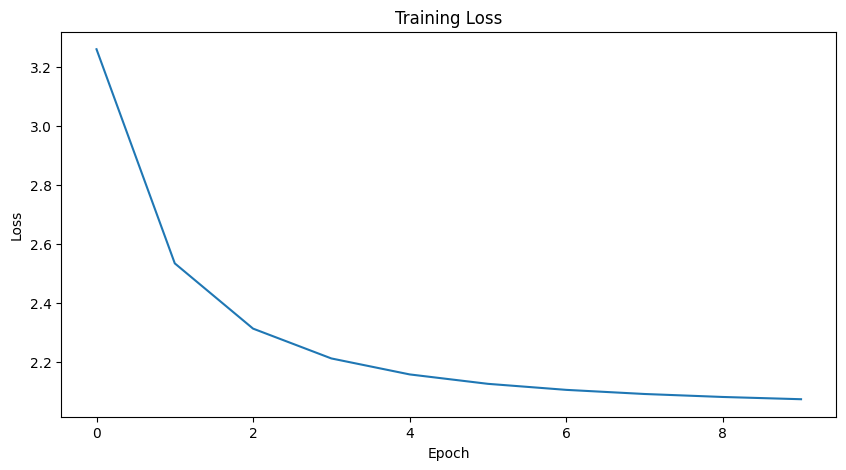

In [18]:
# 绘制损失曲线
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [19]:
# 7. 词向量可视化
def visualize_word_vectors(model, word_to_idx, words_to_visualize=None):
    """可视化词向量"""
    if words_to_visualize is None:
        words_to_visualize = list(word_to_idx.keys())[:50]  # 默认可视化前50个词
    
    # 获取词向量
    vectors = []
    words = []
    for word in words_to_visualize:
        if word in word_to_idx:
            with torch.no_grad():
                vector = model.embeddings(torch.LongTensor([word_to_idx[word]])).numpy()[0]
            vectors.append(vector)
            words.append(word)
    
    vectors = np.array(vectors)


    # 使用t-SNE降维
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(vectors)-1))
    vectors_2d = tsne.fit_transform(vectors)
    # 配置matplotlib支持中文显示 - 跨平台解决方案
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans', 'Bitstream Vera Sans', 'sans-serif']
    plt.rcParams['axes.unicode_minus'] = False
    # 绘制散点图
    plt.figure(figsize=(15, 15))
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])
    
    # 添加词标签，使用中文字体
    for i, word in enumerate(words):
        plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]), fontsize=9)

    
    plt.title('词向量可视化')
    plt.grid(True)
    plt.show()

In [23]:
# 选择一些有代表性的词进行可视化
words_to_visualize = [
    "中国", "北京", "上海",
    "自然语言", "人工智能", "深度学习",
    "词嵌入", "模型", "技术"
]

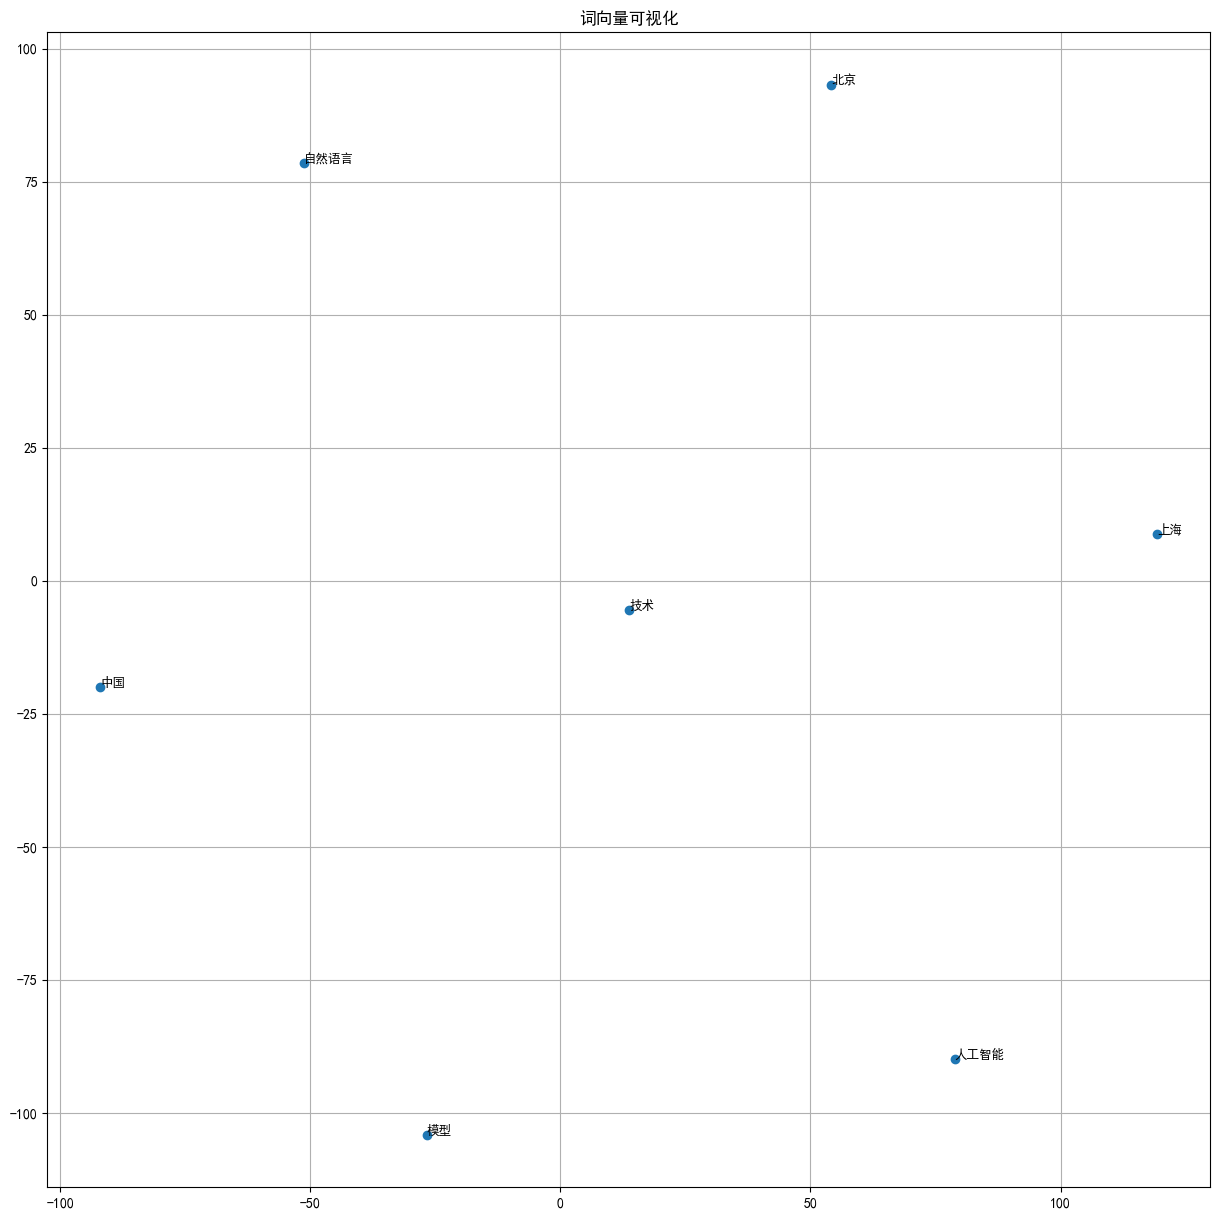

In [24]:
visualize_word_vectors(model, word_to_idx, words_to_visualize)

In [25]:
# 8. 词向量应用
def get_word_vector(model, word_to_idx, word):
    """获取词的向量表示"""
    if word not in word_to_idx:
        return None
    with torch.no_grad():
        word_idx = torch.LongTensor([word_to_idx[word]])
        return model.embeddings(word_idx).numpy()[0]

In [31]:
def find_similar_words(model, word_to_idx, idx_to_word, word, topn=5):
    """查找相似词"""
    if word not in word_to_idx:
        return []
    
    # 获取目标词的向量
    target_vector = get_word_vector(model, word_to_idx, word)
    if target_vector is None:
        return []
    
    # 计算与其他词的余弦相似度
    similarities = []
    for other_word, idx in word_to_idx.items():
        if other_word == word:
            continue
        other_vector = get_word_vector(model, word_to_idx, other_word)
        similarity = np.dot(target_vector, other_vector) / (
            np.linalg.norm(target_vector) * np.linalg.norm(other_vector))
        similarities.append((other_word, similarity))
    
    # 返回最相似的词
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:topn]

In [32]:
# 测试词语相似度
test_words = ["中国", "北京", "人工智能"]
for word in test_words:
    print(f"\n'{word}' 的相似词:")
    similar_words = find_similar_words(model, word_to_idx, idx_to_word, word)
    for similar_word, similarity in similar_words:
        print(f"{similar_word}: {similarity:.4f}")


'中国' 的相似词:
历史: 0.3283
人工智能: 0.3138
分支: 0.2871
广泛应用: 0.2665
一种: 0.2375

'北京' 的相似词:
嵌入: 0.2682
语义: 0.2385
可以: 0.2157
的: 0.1821
理解: 0.1687

'人工智能' 的相似词:
中国: 0.3138
有着: 0.2972
深度: 0.2872
首都: 0.2574
广泛应用: 0.2212
